In [1]:
import torch
import torch.nn as nn
import torchvision
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd

from src.spatial_transformer_former import VariationalSpatialTransformer, Permute

device = torch.device("cuda:0")

# Define some utility functions

In [2]:
def display_images(images):
    if isinstance(images, torch.Tensor):
        images = images.detach().cpu().numpy()
    for i in range(images.shape[0]):
        img = images[i].transpose([1, 2, 0])
        img = img - img.min()
        img = img / img.max()
        plt.imshow(img)
        plt.show()
        
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# Load CIFAR100 data

In [3]:
preprocessor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.0, 1.0)
])

train_dataset = torchvision.datasets.CIFAR10(
    './data/CIFAR100/',
    train=True,
    transform=preprocessor
)
train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    num_workers=3,
    persistent_workers=True
)

test_dataset = torchvision.datasets.CIFAR10(
    './data/CIFAR100/',
    train=False,
    transform=preprocessor
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=1,
    persistent_workers=True
)

In [4]:
print(f"train: {len(train_dataset)}, test: {len(test_dataset)}")

train: 50000, test: 10000


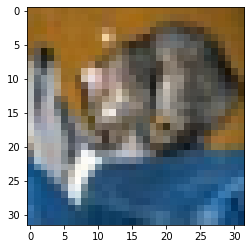

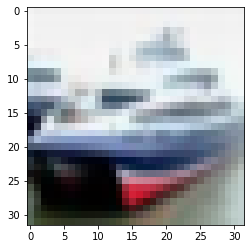

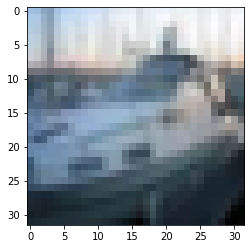

In [6]:
for img, label in test_data_loader:
    break
img = img[:3]
display_images(img)

In [14]:
st = VariationalSpatialTransformer(
    loc_layer=torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
        torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
        torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    ),
    image_shape=(3, 32, 32),
    target_shape=(3, 128, 128),
    num_heads=32,
    initial_sigma=0.25
)

In [17]:
%%time
output = st(x=img)

Wall time: 65 ms


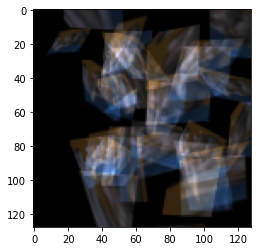

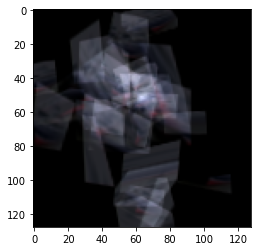

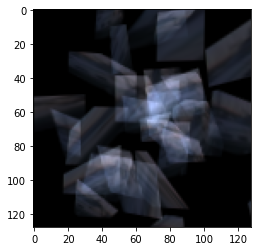

In [18]:
display_images(output)

In [5]:
sst_model = torch.nn.Sequential(
    VariationalSpatialTransformer(
        loc_layer=torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        ),
        image_shape=(3, 32, 32),
        target_shape=(3, 128, 128),
        num_heads=16,
        initial_sigma=0.25
    ),
    nn.Tanh(),
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding="same"),
    torch.nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding="same"),
    torch.nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    VariationalSpatialTransformer(
        loc_layer=torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        ),
        image_shape=(32, 32, 32),
        target_shape=(32, 128, 128),
        num_heads=16,
        initial_sigma=0.25
    ),
    nn.Tanh(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same"),
    torch.nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding="same"),
    torch.nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    VariationalSpatialTransformer(
        loc_layer=torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        ),
        image_shape=(32, 32, 32),
        target_shape=(32, 128, 128),
        num_heads=16,
        initial_sigma=0.25
    ),
    nn.Tanh(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same"),
    torch.nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same"),
    torch.nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same"),
    torch.nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same"),
    torch.nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same"),
    torch.nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Flatten(1, 3),
    nn.Linear(in_features=1024, out_features=100),
    nn.LogSoftmax(dim=1)
).to(device)

In [6]:
loss_fn = nn.NLLLoss()
optimizer = torch.optim.AdamW(
    params=sst_model.parameters(),
    lr=0.0001,
    weight_decay=0.01,
)

In [ ]:
EPOCHS = 20
MINIBATCH_SIZE = 64
GRAD_NORM = 0.1
GRAD_VALUE = 0.1

test_history = []
train_history = []
step = 0
with tqdm(desc="Training", unit="samples", total=len(train_dataset)*EPOCHS, leave=True) as pbar:
    for epoch in range(20):
        sst_model.eval()
        with torch.no_grad():
            total_losses = []
            total_correct = []
            for test_batch, test_batch_labels in tqdm(test_data_loader, desc="Evaluating", position=1, leave=False):
                test_batch, test_batch_labels = test_batch.to(device), test_batch_labels.to(device)
                log_probas = sst_model(test_batch)
                loss = loss_fn(log_probas, test_batch_labels)
                y_hat = log_probas.argmax(dim=1)
                correct = (y_hat==test_batch_labels).to(torch.float32)
                total_losses.append(loss.detach())
                total_correct.append(correct.detach())
            test_loss = torch.stack(total_losses, dim=0).mean(dim=0).cpu().item()
            test_accuracy = torch.concat(total_correct, dim=0).mean(dim=0).cpu().item()
            test_history.append({
                "epoch": epoch,
                "step": step,
                "loss": test_loss,
                "accuracy": test_accuracy,
            })
            pd.DataFrame.from_records(test_history).to_csv("test_history.csv", index=False)
        
        sst_model.train()
        for train_batch, train_batch_labels in train_data_loader:
            y_hats = []
            train_losses = []
            
            for train_minibatch, train_minibatch_labels in zip(chunks(train_batch, MINIBATCH_SIZE), chunks(train_batch_labels, MINIBATCH_SIZE)):
                train_minibatch, train_minibatch_labels = train_minibatch.to(device), train_minibatch_labels.to(device)
                log_probas = sst_model(train_minibatch)
                loss = loss_fn(log_probas, train_minibatch_labels)
                loss = loss * train_minibatch.shape[0]/train_batch.shape[0]
                loss.backward()
                train_losses.append(loss.detach())
                y_hats.append(log_probas.detach().argmax(dim=1))
            nn.utils.clip_grad_value_(sst_model.parameters(), GRAD_VALUE)
            nn.utils.clip_grad_norm_(sst_model.parameters(), GRAD_NORM)
            optimizer.step()
            step += 1
            loss = torch.stack(train_losses, dim=0).sum()
            y_hat = torch.concat(y_hats, dim=0)
            train_accuracy = (y_hat.cpu()==train_batch_labels).to(torch.float32).mean(dim=0)
            train_history.append(
                {
                    "epoch": epoch,
                    "step": step,
                    "loss": loss.detach().cpu().item(),
                    "accuracy": train_accuracy.detach().cpu().item(),
                }
            )
            pbar.set_postfix(train_history[-1])
            pbar.update(train_batch.shape[0])
            if step % 5 == 0:
                pd.DataFrame.from_records(train_history).to_csv("train_history.csv", index=False)
            

Training:   0%|          | 0/1000000 [00:00<?, ?samples/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]